<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from scipy import stats

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape


(1460, 81)

In [4]:
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

<b>

There are quite a number of null values.

For each category, the null/na values likely mean that the particular property does not have that feature e.g. pools

</b>

In [5]:
#Check what are the zoning classification groups

house.MSZoning.unique()

#house = house[house['MSZoning'].isin([''])]

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [6]:
#remove commercial zoning as we are only interested in the residential

house = house[house['MSZoning'].isin(['RL','RM','FV','RH'])]

house.MSZoning.unique()

array(['RL', 'RM', 'FV', 'RH'], dtype=object)

In [7]:
#drop ID as it is not a useful feature to us

house.drop('Id',axis=1,inplace=True)

In [8]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [9]:
#identify the fixed properties

#these are the column names for the features that have been identified to be FIXED
fixed_cols = ['MSSubClass','MSZoning',
             'LotFrontage',
             'LotArea',
             'Street',
             'Alley',
             'LotShape',
             'LandContour',
             'Utilities',
             'LotConfig',
             'LandSlope',
             'Neighborhood',
             'Condition1',
             'Condition2',
             'BldgType',
             'HouseStyle',
              'YearBuilt',
              'Foundation',
              'BsmtQual',
              'BsmtExposure',
              'TotalBsmtSF',
              '1stFlrSF',
              '2ndFlrSF',
              'GrLivArea',
              'BsmtFullBath', 
              'BsmtHalfBath', 
              'FullBath','HalfBath', 
              'BedroomAbvGr', 'KitchenAbvGr',
              'TotRmsAbvGrd', 'Fireplaces',
              'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea',
              'WoodDeckSF', 'OpenPorchSF',
              'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
              'MoSold', 'YrSold', 'SaleType',
              'SaleCondition','SalePrice'
             ]


In [10]:
house_fixed = house[fixed_cols]


In [11]:
house_fixed.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
YearBuilt          int64
Foundation        object
BsmtQual          object
BsmtExposure      object
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageType        object
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64


In [12]:
#change the null values to something appropriate so they will be considered as a "category"

house_fixed.fillna("None",inplace=True)



C:\Users\Kai Hee\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [13]:
#write function that will create dummy variables whenever datatype is an object/string as linear regression would not work
#with categorical variables

def create_dummy(colname,df):

    if(df[colname].dtype == object):
    
        dummy = pd.get_dummies(house[colname])

        dummy.columns = [colname + str(col) for col in dummy.columns]

        #drop one reference category (the last col)

        dummy = dummy.iloc[:,0:-1]

        # Join the dummy variables to the main dataframe
        df = pd.concat([df, dummy], axis=1)

        #drop the original column that was converted to dummy variables

        df.drop([colname],axis=1,inplace=True)
        
        
    return df

In [14]:

#run the function on each of the columns in the dataset

for f in fixed_cols:
    house_fixed = create_dummy(f,house_fixed)
    

In [15]:
#create more dummy variables where required (MSSubClass is int64, not an object and is a categorical variable)

df_MSSub = pd.get_dummies(house['MSSubClass'])

df_MSSub.columns = ['MSSub_' + str(col) for col in df_MSSub.columns]


In [16]:
#drop one reference category

df_MSSub.drop(['MSSub_20'],axis=1,inplace=True)

# Join the dummy variables to the main dataframe
house_fixed = pd.concat([house_fixed, df_MSSub], axis=1)


In [17]:
#drop the original column that was converted to dummy variables

house_fixed.drop(['MSSubClass'],axis=1,inplace=True)


In [18]:

#shift SalePrice (target) to the last column

price = house_fixed.SalePrice
yrsold = house_fixed.YrSold

house_fixed.drop('SalePrice',axis=1,inplace=True)#remove column

house_fixed['SalePrice'] = price#add column back so it is the last column


In [19]:
#identify the features most highly correlated to the Sale Price

house_fixed.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
1stFlrSF        0.603300
FullBath        0.556674
BsmtQualEx      0.554251
TotRmsAbvGrd    0.533355
YearBuilt       0.517602
Name: SalePrice, dtype: float64

In [20]:
#pick the 10 features with highest correlation as predictors for price

predictors = ['GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','BsmtQualEx','TotRmsAbvGrd','YearBuilt']


In [21]:

#sales data are from years 2006 - 2010
#split into training set (prior to 2010) and test set (2010 houses)

#only pick the columns with the selected features
house_fixed2 = house_fixed[predictors]
house_fixed2['SalePrice'] = price

data_train = house_fixed2[house_fixed['YrSold']<2010]

data_test = house_fixed2[house_fixed['YrSold']==2010]


y_train = data_train.SalePrice.values

y_test = data_test.SalePrice.values

X_train = data_train.iloc[:,0:-1]

X_test = data_test.iloc[:,0:-1]


ss = StandardScaler()

# Use the "fit_transform" function to standardize the X design matrix.
Xs_train = ss.fit_transform(X_train)

Xs_test = ss.fit_transform(X_test)


C:\Users\Kai Hee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.parti

In [22]:
linreg = LinearRegression()

lr = linreg.fit(Xs_train,y_train)

linreg_scores = cross_val_score(lr, Xs_test, y_test, cv=10)

print(linreg_scores)
print('The R^2 Score for Linear Regression Model is', np.mean(linreg_scores))


[0.69539153 0.78194418 0.69144425 0.74989501 0.65627751 0.7398257
 0.73915807 0.86247732 0.79764685 0.84800286]
The R^2 Score for Linear Regression Model is 0.7562063280678639


<b> The Linear Regression model performs fairly well without any regularisation with an R^2 score of 0.756 </b>

In [23]:
#Attempt with ridge model to see if R^2 score can be improved

ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print(optimal_ridge.alpha_)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_test, y_test, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

47.14866363457394
[0.73967761 0.79486414 0.75844123 0.780209   0.80908343 0.69676698
 0.72230544 0.90325344 0.72854487 0.7775129 ]
0.7710659053264404


C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<b> The Ridge model performs significantly better with a score of 0.771</b>

In [24]:
#Attempt with lasso model to see if R^2 score can be improved

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_test, y_test, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[0.68763796 0.78399322 0.70305392 0.76782463 0.76526192 0.73628099
 0.73442396 0.89011069 0.78306002 0.8388627 ]
0.7690510006795817


<b> The lasso model performs similarly to the ridge model with a score of 0.769, possibly because the number of features selected was small to begin with (10 features) </b>

In [25]:
#take a look at the lasso coefficients

lasso.fit(Xs_train, y_train)


lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
0,GrLivArea,34481.107506,34481.107506
6,BsmtQualEx,17218.011420,17218.011420
8,YearBuilt,15222.589374,15222.589374
1,GarageCars,12879.776132,12879.776132
3,TotalBsmtSF,11537.421695,11537.421695
2,GarageArea,1027.605125,1027.605125
4,1stFlrSF,0.000000,0.000000
5,FullBath,0.000000,0.000000
7,TotRmsAbvGrd,-0.000000,0.000000


In [26]:
print('Proportion of variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Proportion of variables zeroed out: 0.3333333333333333


<b> 3 variables were zeroed out by the lasso model: Area of 1st floor in Square feet, Number of Full Baths and total number of rooms above ground <b>

In [27]:
#attempt elastic net model

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(Xs_train, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

1571.8756006165493
1.0


In [28]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_test, y_test, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

[0.68933354 0.786625   0.70552028 0.7684548  0.77751577 0.73555413
 0.73089849 0.89254683 0.782697   0.83896576]
0.7708111587095804


<b> The elastic net model performs similarly to the ridge model with a score of 0.771</b>

<b> 
    
From the model, the best estimators of price are 

1) Above Ground Living Area (Sq Feet)

2) Basement Height

3) Year the house was built

4) Size of Garage in car capacity

5) Area of Basement (Sq Feet)


</b>


In [29]:
#lets find and plot the residuals of our best model, the ridge model
# predict y values based on fitted model
df = pd.DataFrame()

ridge.fit(Xs_train, y_train)

#predict on test set
rpredict_test = ridge.predict(X_test)

#predict on training set
rpredict_train = ridge.predict(X_train)

df['Pred_test'] = rpredict_test
df['SalePrice'] = y_test


C:\Users\Kai Hee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


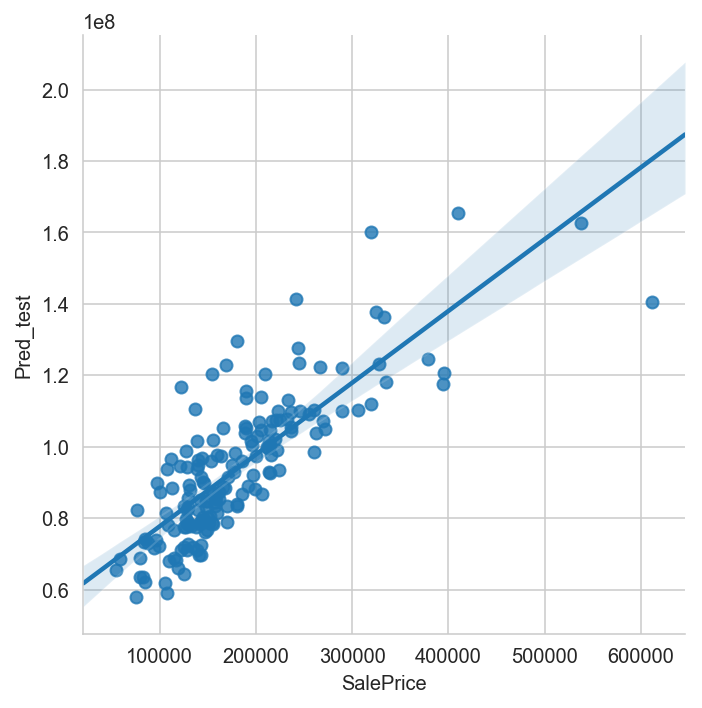

In [30]:
# Plot the model against the true values to see the residuals
sns.lmplot(x='SalePrice', y='Pred_test', data=df)

<b> The model seems to fit the data quite well for low sale prices, however the relationshop seems to become non-linear at higher sale prices </b>

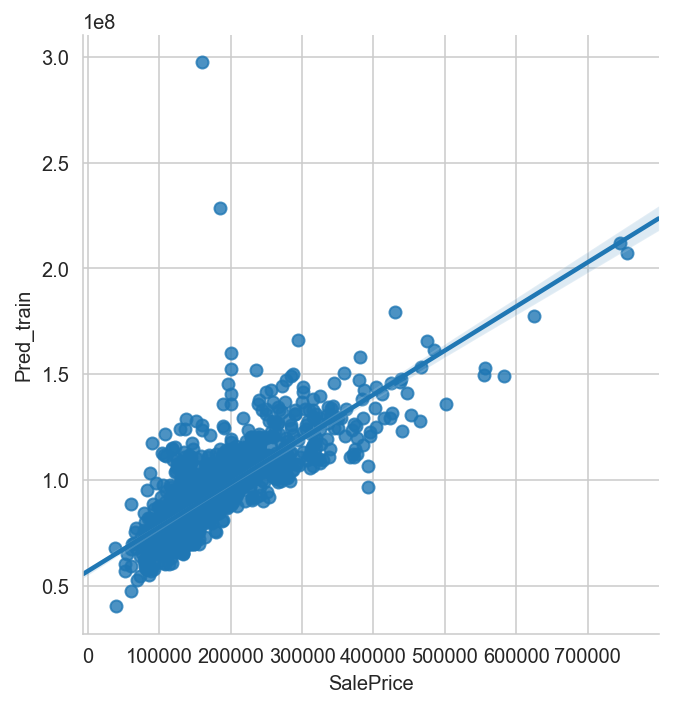

In [31]:
df2 = pd.DataFrame()

df2['Pred_train'] = rpredict_train
df2['SalePrice'] = y_train

# Plot the model against the true values to see the residuals
sns.lmplot(x='SalePrice', y='Pred_train', data=df2)

#save the residuals to be used in Question 2
df['Residuals_test'] = y_test-rpredict_test
df2['Residuals_train'] = y_train-rpredict_train


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [32]:
#identify the non-static or changeable property characteristics

change_cols = [ 'OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtCond',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'Heating', 'HeatingQC',
       'CentralAir', 'Electrical',
       'Functional', 'FireplaceQu',
       'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal','YrSold','SalePrice']


In [33]:
#this is the dataset with the changeable attributes only

house_change = house[change_cols]


In [34]:
#if the house has never been remodelled, YearRemodAdd = YrBuilt
#we can create a new column that tells us if the house has been remodelled or not

house_change['Remodelled'] = house['YearBuilt']<house['YearRemodAdd']

house_change['Remodelled'] = house_change['Remodelled'].replace(False,0).astype(int)
house_change['Remodelled'] = house_change['Remodelled'].replace(True,1).astype(int)

house_change['Remodelled'].value_counts()

C:\Users\Kai Hee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Kai Hee\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kai Hee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

0    763
1    687
Name: Remodelled, dtype: int64

<b> We note that 763 (52.6%) of the properties have not been renovated/remodelled while 687 (47.4%) of the properties have. </b>

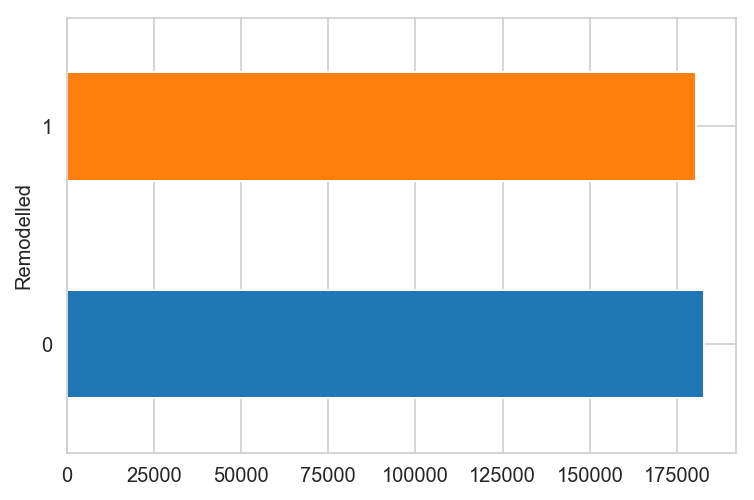

In [35]:
#We can explore what's the average sale price for houses that have been remodelled versus houses that have not

house_change.groupby('Remodelled')['SalePrice'].mean().plot(kind='barh')

In [36]:
house_change.groupby('Remodelled')['SalePrice'].mean()

Remodelled
0    182749.571429
1    180439.218341
Name: SalePrice, dtype: float64

<b>It seems that the average sale price for remodelled home is actually slightly lower than that of homes that have not been remodelled</b>

In [37]:
#check for null values
house_change.isnull().sum()

OverallQual        0
OverallCond        0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
BsmtCond          37
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
Functional         0
FireplaceQu      681
GarageFinish      79
GarageQual        79
GarageCond        79
PavedDrive         0
PoolQC          1443
Fence           1172
MiscFeature     1398
MiscVal            0
YrSold             0
SalePrice          0
Remodelled         0
dtype: int64

In [38]:
#change the null values to something appropriate so they will be considered as a "category"

house_change.fillna("None",inplace=True)


C:\Users\Kai Hee\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [39]:
#again, we create dummy variables where required using the function created earlier

#run the function on each of the columns in the dataset

for f in change_cols:
    house_change = create_dummy(f,house_change)
    

In [40]:
#identify the features most highly correlated to the Sale Price

#we'll use the top 10 most highly correlated variables as the features

house_change.corr()['SalePrice'].sort_values(ascending=False).head(10)

SalePrice          1.000000
OverallQual        0.789031
YearRemodAdd       0.501186
ExterQualEx        0.452509
ExterQualGd        0.449738
BsmtFinType1GLQ    0.432266
HeatingQCEx        0.430411
GarageFinishFin    0.417753
BsmtFinSF1         0.384475
FireplaceQuGd      0.337766
Name: SalePrice, dtype: float64

In [41]:
predictors = ['OverallQual','YearRemodAdd','ExterQualEx','ExterQualGd','BsmtFinType1GLQ','HeatingQCEx','GarageFinishFin',
             'BsmtFinSF1','FireplaceQuGd']

In [42]:
#only pick the columns with the selected features
house_change2 = house_change[predictors]
house_change2['SalePrice'] = price


#we manually split the dataset into training and test
data_train = house_change2[house_change['YrSold']<2010]

data_test = house_change2[house_change['YrSold']==2010]


#our target variable is the remaining variance in price from the first model, thus we should subtract off the predicted price
#from the first model to derive the residuals

y_train = data_train.SalePrice.values - rpredict_train

y_test = data_test.SalePrice.values - rpredict_test

X_train = data_train.iloc[:,0:-1]

X_test = data_test.iloc[:,0:-1]


ss = StandardScaler()

# Use the "fit_transform" function to standardize the X design matrix.
Xs_train = ss.fit_transform(X_train)

Xs_test = ss.fit_transform(X_test)


C:\Users\Kai Hee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64

In [43]:
#Attempt linear regression model first

linreg = LinearRegression()

lr = linreg.fit(Xs_train,y_train)

linreg_scores = cross_val_score(lr, Xs_test, y_test, cv=10)

print(linreg_scores)
print('The R^2 Score for Linear Regression Model is', np.mean(linreg_scores))

[ 0.23483663  0.22842562  0.59878887  0.42336193 -0.18182081  0.64467415
  0.40273592  0.59512093  0.41183383  0.28897921]
The R^2 Score for Linear Regression Model is 0.36469362891057167


<b>The R^2 Score for Linear Regression Model is 0.365</b>

In [44]:
#Attempt with ridge model to see if R^2 score can be improved

ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print(optimal_ridge.alpha_)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_test, y_test, cv=10)

print(ridge_scores)
print('The R^2 score for the ridge model is', np.mean(ridge_scores))

30.888435964774818
[ 0.31620589  0.26612714  0.61460857  0.4256305  -0.2125176   0.61835464
  0.43163957  0.5334652   0.3822361   0.30880383]
The R^2 score for the ridge model is 0.3684553849262063


<b>The R^2 score for the ridge model is 0.368</b>

In [45]:
#Attempt with lasso model to see if R^2 score can be improved

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_test, y_test, cv=10)

print(lasso_scores)
print('The R^2 score for the lasso model is', np.mean(lasso_scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

13988.018998022777
[ 0.23633844  0.2299209   0.59831199  0.42324429 -0.18116133  0.6435123
  0.40325903  0.59425612  0.41254599  0.28893241]
The R^2 score for the lasso model is 0.3649160150533842


.................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished


<b>The R^2 score for the lasso model is 0.365</b>

In [46]:
#take a look at the lasso coefficients

lasso.fit(Xs_train, y_train)

lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
0,OverallQual,-1.255423e+07,1.255423e+07
7,BsmtFinSF1,-4.895348e+06,4.895348e+06
4,BsmtFinType1GLQ,3.159049e+06,3.159049e+06
2,ExterQualEx,-1.330937e+06,1.330937e+06
8,FireplaceQuGd,-1.062332e+06,1.062332e+06
3,ExterQualGd,-1.044264e+06,1.044264e+06
6,GarageFinishFin,-8.021107e+05,8.021107e+05
1,YearRemodAdd,3.735417e+05,3.735417e+05
5,HeatingQCEx,-1.512025e+05,1.512025e+05


In [47]:
print('Proportion of variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Proportion of variables zeroed out: 0.0


In [48]:
#attempt elastic net model

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10)
optimal_enet.fit(Xs_train, y_train)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_test, y_test, cv=10)

print(enet_scores)
print('The R^2 score for the elastic net model is', np.mean(enet_scores))

[ 0.23633844  0.2299209   0.59831199  0.42324429 -0.18116133  0.6435123
  0.40325903  0.59425612  0.41254599  0.28893241]
The R^2 score for the elastic net model is 0.3649160150533842


<b> Of all the models, the ridge model performs the best by a slight margin with an R^2 score of 0.368</b>

C:\Users\Kai Hee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


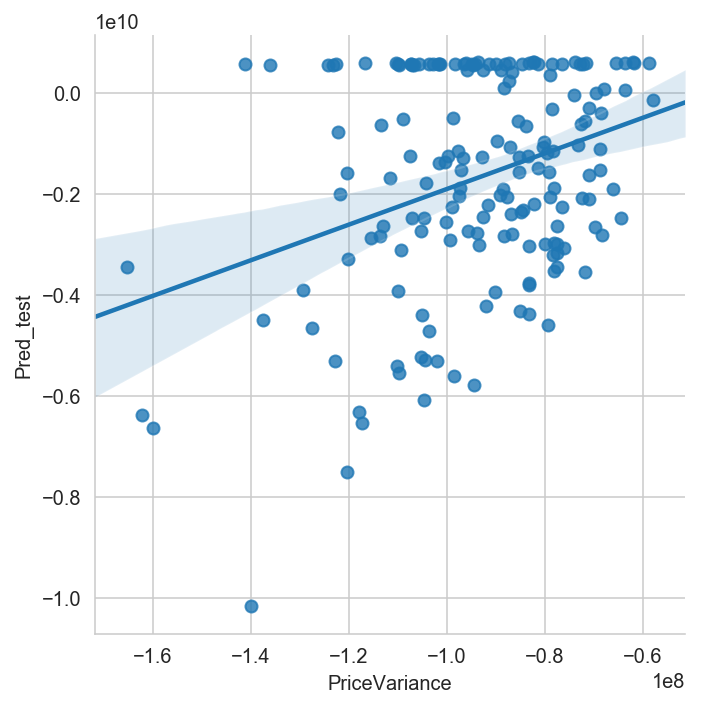

In [49]:
#lets find and plot the residuals of our model
# predict y values based on fitted model
df3 = pd.DataFrame()

er = enet.fit(Xs_train,y_train)

#predict on test set
erpredict_test = er.predict(X_test)

#predict on training set
erpredict_train = er.predict(X_train)

df3['Pred_test'] = erpredict_test
df3['PriceVariance'] = y_test


# Plot the model against the true values to see the residuals
sns.lmplot(x='PriceVariance', y='Pred_test', data=df3)


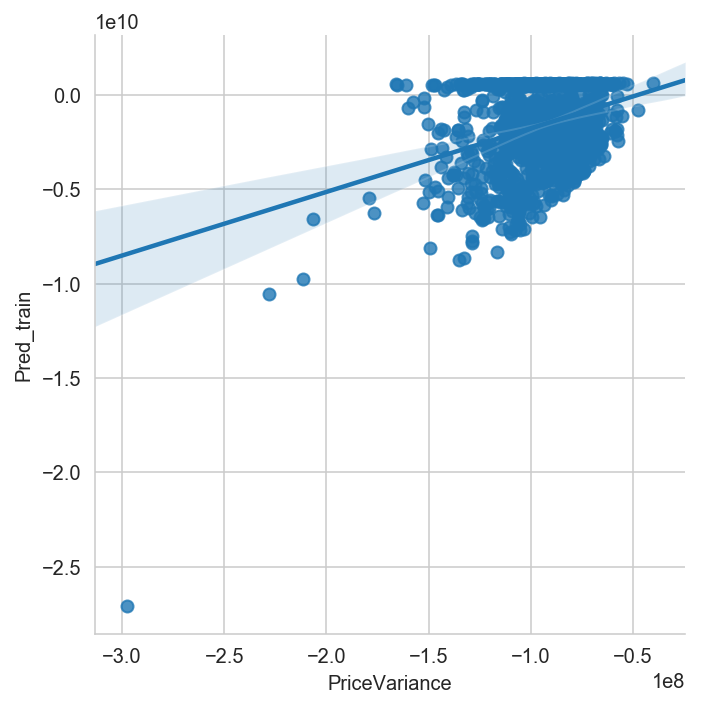

In [50]:
df4 = pd.DataFrame()

df4['Pred_train'] = erpredict_train
df4['PriceVariance'] = y_train

# Plot the model against the true values to see the residuals
sns.lmplot(x='PriceVariance', y='Pred_train', data=df4)

#save the residuals to be used in Question 2
df3['Residuals_test'] = y_test-erpredict_test
df4['Residuals_train'] = y_train-erpredict_train

<b> As the R^2 score is moderate, we can conclude that renovation does have some impact on the variance in sale price, but the effect is not that strong. Furthermore, from initial EDA, the average sale price of the houses was actually lower for properties that had been remodelled.  </b>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [51]:
house.SaleCondition.value_counts()

house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<b>There are multiple categories of Sale Condition, of which Abonormal sales only make up 6.6% of the total transactions. 
</b>

In [52]:
#do some feature engineering to create a new column that indicates whether sale condition is abnormal or not

house['abnormal'] = house.SaleCondition=='Abnorml'

house['abnormal'] = house['abnormal'].replace(False,0).astype(int)
house['abnormal'] = house['abnormal'].replace(True,1).astype(int)

#drop the original sale condition column

house.drop('SaleCondition',axis=1,inplace=True)


In [53]:
#calculate the baseline accuracy (% of the majority class)

house['abnormal'].value_counts()

0    1354
1      96
Name: abnormal, dtype: int64

<b> Baseline accuracy is 93.37% <b>

In [54]:
#change the null values to something appropriate so they will be considered as a "category"

house.fillna("None",inplace=True)

In [55]:
#We will look at all columns for this portion to determine which features predict the Abnormal category

#run the dummy creation function on each of the columns in the dataset

for f in house.columns:
    house = create_dummy(f,house)

In [56]:
#create more dummy variables where required (MSSubClass is int64, not an object and is a categorical variable)

df_MSSub = pd.get_dummies(house['MSSubClass'])

df_MSSub.columns = ['MSSub_' + str(col) for col in df_MSSub.columns]


#drop one reference category

df_MSSub.drop(['MSSub_20'],axis=1,inplace=True)

# Join the dummy variables to the main dataframe
house = pd.concat([house, df_MSSub], axis=1)


#drop the original column that was converted to dummy variables

house.drop(['MSSubClass'],axis=1,inplace=True)


In [57]:
#look at the correlation coefficients to see if any of the features are strongly correlated with abnormal sale conditions

#we'll use the top 10 most highly correlated variables as the features

house.corr()['abnormal'].sort_values(ascending=False).head(10)

abnormal            1.000000
SaleTypeCOD         0.339439
SaleTypeOth         0.171002
Exterior1stStone    0.139574
PoolQCEx            0.139574
MSZoningRH          0.104631
MasVnrArea237.0     0.098660
MasVnrArea294.0     0.098660
MasVnrArea366.0     0.098660
LotFrontage160.0    0.098660
Name: abnormal, dtype: float64

In [58]:
#Attempt logistic regression to do classification analysis using the 5 features with the highest correlation coefficients

sm.logit(formula='abnormal ~ SaleTypeCOD + SaleTypeOth + Exterior1stStone + PoolQCEx + MSZoningRH',data=house).fit(maxiter=500,method='bfgs').summary()


         

Optimization terminated successfully.
         Current function value: 0.201447
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               abnormal   No. Observations:                 1450
Model:                          Logit   Df Residuals:                     1444
Method:                           MLE   Df Model:                            5
Date:                Fri, 18 Jan 2019   Pseudo R-squ.:                  0.1734
Time:                        00:56:18   Log-Likelihood:                -292.10
converged:                       True   LL-Null:                       -353.39
                                        LLR p-value:                 8.922e-25
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.0476      0.129    -23.634      0.000      -3.300      -2.795
SaleTypeCOD          3.2118      0.345      9.322      0.000       2.537       3.887
SaleTypeOth         17.4560    776.560      0.022      0.982   -1504.574    1539.485
Exterior1stStone     8.9752     19.042      0.471      0.637     -28.346      46.296
PoolQCEx            12.9742    101.164      0.128      0.898    -185.304     211.252
MSZoningRH           2.0683      0.585      3.536      0.000       0.922       3.215
====================================================================================
"""

In [59]:
#for cross validation
#we manually split the dataset into training and test
data_train = house[house['YrSold']<2010]

data_test = house[house['YrSold']==2010]


#our target variable is the remaining variance in price from the first model, thus we should subtract off the predicted price
#from the first model to derive the residuals

y_train = data_train.abnormal.values

y_test = data_test.abnormal.values

X_train = data_train.iloc[:,0:-1]

X_test = data_test.iloc[:,0:-1]


ss = StandardScaler()

# Use the "fit_transform" function to standardize the X design matrix.
Xs_train = ss.fit_transform(X_train)

Xs_test = ss.fit_transform(X_test)

C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kai Hee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


<b> From the coefficients of the logistic regression and the p-values (where < 0.05), we see that Sale Type = COD and MSZoning = Residential High Density are positive predictors of abnormal sales. </b>

In [60]:
#let's run logistic regression with cross validation

lr = LogisticRegressionCV(Cs=200, cv=25)
lr.fit(Xs_train, y_train)

print(lr.scores_)

{1: array([[0.92307692, 0.92307692, 0.92307692, ..., 1.        , 1.        ,
        1.        ],
       [0.92307692, 0.92307692, 0.92307692, ..., 1.        , 1.        ,
        1.        ],
       [0.92307692, 0.92307692, 0.92307692, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.94      , 0.94      , 0.94      , ..., 1.        , 1.        ,
        1.        ],
       [0.94      , 0.94      , 0.94      , ..., 1.        , 1.        ,
        1.        ],
       [0.94      , 0.94      , 0.94      , ..., 1.        , 1.        ,
        1.        ]])}


<b> Answer: </b>

As there is severe class imbalance between the abnormal sales and the normal sales(all other categories), we should use some other performance measures to give more insight to the accuracy of the model such as using the confusion matrix, AUC, ROC and precision and recall.

<b> Calculate the predicted labels and predicted probabilities on the test set with the Ridge logistic regression </b>

In [61]:
yhat = lr.predict(X_test)
yhat_pp = lr.predict_proba(X_test)

In [62]:
#let's take a look at the confusion matrix for the logistic regression classifier

conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_abnormal', 'is_normal'],
                         columns=['predicted_abnormal','predicted_normal'])
confusion

,predicted_abnormal,predicted_normal
is_abnormal,0,9
is_normal,0,163


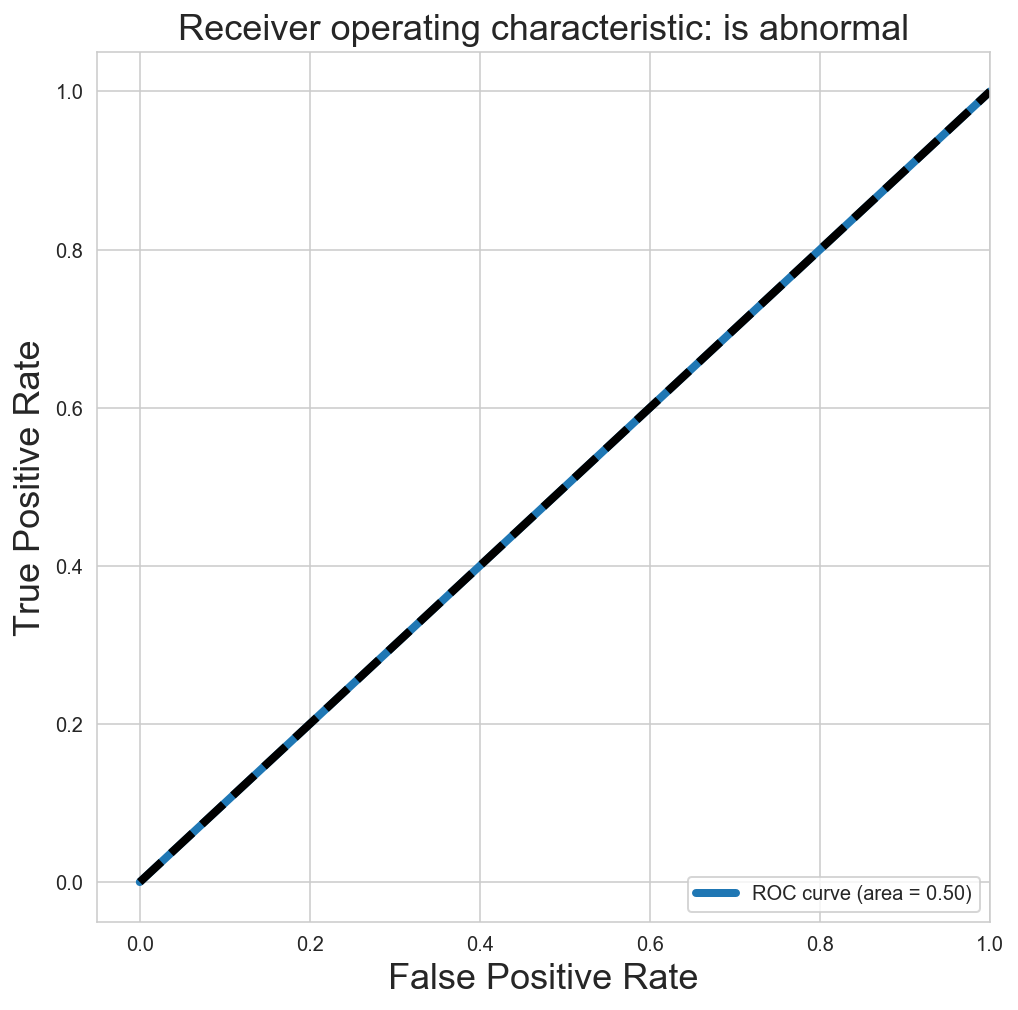

In [63]:
# predictions and pred prob.
yhat = lr.predict(X_test)
yhat_pp = lr.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is abnormal', fontsize=18)
plt.legend(loc="lower right")
plt.show()